In [ ]:
import pandas as pd
import os
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time, os, copy
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.models import *

from PIL import Image

from tqdm import tqdm

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *



In [78]:
train_directory = 'data/training/'
valid_directory = 'data/validation/'
test_directory  = 'data/files_for_testing/'

In [79]:
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(1, 7, figsize=(30, 30))  
    axes = axes.flatten() 
    for img, label, ax in zip(images_arr, labels, axes): 
        ax.imshow(img)  
        ax.set_title(label)
        ax.axis('off') 
    plt.tight_layout()  
    plt.show()  

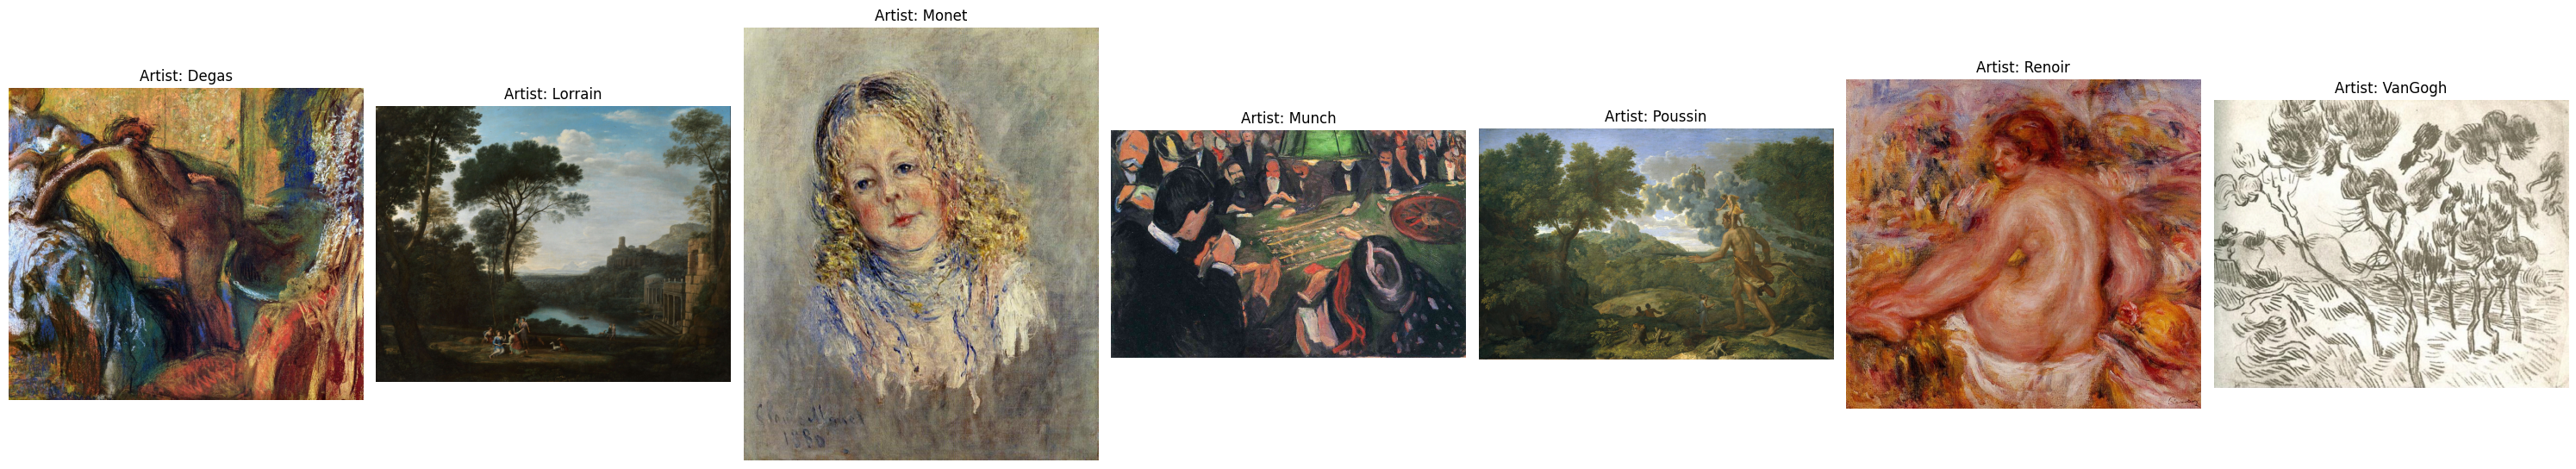

In [80]:
images_arr = []
labels = []

painters = [d for d in os.listdir(train_directory) if os.path.isdir(os.path.join(train_directory, d))]
for painter in painters:
    tr_directory = os.path.join(train_directory, painter)
    image_files = [filename for filename in os.listdir(tr_directory) if filename.endswith('.jpg')]
    if image_files: 
        img = Image.open(os.path.join(tr_directory, image_files[12]))
        images_arr.append(img)
        labels.append("Artist: " + painter)

plotImages(images_arr, labels)

In [15]:
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [16]:
dataset = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

In [17]:
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'valid', 'test']}
print(f"Rozmiary datasetów: {dataset_sizes}")

Rozmiary datasetów: {'train': 4352, 'valid': 1159, 'test': 295}


In [18]:
class_names = dataset['train'].classes
print("Klasy:", class_names)

Klasy: ['Degas', 'Lorrain', 'Monet', 'Munch', 'Poussin', 'Renoir', 'VanGogh']


In [19]:
from collections import Counter

class_labels = dataset['train'].targets
class_counts = Counter(class_labels)


In [ ]:
class_counts_df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])
class_counts_df['Class Name'] = [class_names[idx] for idx in class_counts_df['Class']]
class_counts_df['Class Weight'] = class_counts_df['Count'].sum() / (class_counts_df['Count'] * class_counts_df.shape[0])

print("Liczność klas w zbiorze treningowym:")
print(class_counts_df)

Liczność klas w zbiorze treningowym:
   Class  Count Class Name  Class Weight
0      0    469      Degas      1.325617
1      1     77    Lorrain      8.074212
2      2   1025      Monet      0.606551
3      3    146      Munch      4.258317
4      4    129    Poussin      4.819491
5      5   1059     Renoir      0.587077
6      6   1447    VanGogh      0.429657


In [21]:
class_weights = {idx: weight for idx, weight in enumerate(class_counts_df['Class Weight'])}
print("Wagi klas:", class_weights)

Wagi klas: {0: 1.325616813889735, 1: 8.074211502782932, 2: 0.6065505226480836, 3: 4.258317025440313, 4: 4.819490586932448, 5: 0.5870767570484284, 6: 0.42965741929114426}


In [22]:
from torch.utils.data import DataLoader, WeightedRandomSampler

sample_weights = [class_weights[label] for label in class_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [23]:
batch_size = 64
train_loader = DataLoader(dataset['train'], batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(dataset['valid'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False)

print("DataLoader przygotowany.")

DataLoader przygotowany.


In [48]:
from sklearn.utils.class_weight import compute_class_weight

model = models.resnet50(pretrained=True)
n_classes = len(dataset['train'].classes)  

for name, param in model.named_parameters():
    if 'layer3' in name or 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, n_classes)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=torch.arange(n_classes).numpy(),
    y=dataset['train'].targets
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

c:\Users\Administrator\Desktop\MasterThesis\magisterka\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Administrator\Desktop\MasterThesis\magisterka\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
def train_model_with_tracking(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, log_interval=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    early_stopping_patience = 10
    early_stopping_counter = 0

    metrics_history = {
        'train_loss': [],
        'valid_loss': [],
        'train_f1': [],
        'valid_f1': [],
        'train_precision': [],
        'valid_precision': [],
        'train_recall': [],
        'valid_recall': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            y_true = []
            y_pred = []

            loop = tqdm(enumerate(dataloaders[phase]), total=len(dataloaders[phase]), desc=f'{phase} Phase')
            for batch_idx, (inputs, labels) in loop:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

            # Obliczanie wyników dla epoki
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_f1 = f1_score(y_true, y_pred, average='weighted')
            epoch_precision = precision_score(y_true, y_pred, average='weighted')
            epoch_recall = recall_score(y_true, y_pred, average='weighted')

            if phase == 'train':
                metrics_history['train_loss'].append(epoch_loss)
                metrics_history['train_f1'].append(epoch_f1)
                metrics_history['train_precision'].append(epoch_precision)
                metrics_history['train_recall'].append(epoch_recall)
            else:
                metrics_history['valid_loss'].append(epoch_loss)
                metrics_history['valid_f1'].append(epoch_f1)
                metrics_history['valid_precision'].append(epoch_precision)
                metrics_history['valid_recall'].append(epoch_recall)

            print(f'{phase} Loss: {epoch_loss:.4f} F1: {epoch_f1:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f}')

            if phase == 'valid':
                scheduler.step()
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= early_stopping_patience:
                        print("Early stopping triggered.")
                        model.load_state_dict(best_model_wts)
                        return model, metrics_history

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best F1: {best_f1:.4f}')

    model.load_state_dict(best_model_wts)
    return model, metrics_history

dataloaders = {'train': train_loader, 'valid': valid_loader}
model, metrics_history = train_model_with_tracking(model, dataloaders, criterion, optimizer, scheduler, num_epochs=11)


Epoch 0/10
----------


train Phase:   0%|          | 0/68 [00:00<?, ?it/s]

train Phase: 100%|██████████| 68/68 [04:58<00:00,  4.38s/it]


train Loss: 0.7650 F1: 0.2705 Precision: 0.3418 Recall: 0.3856


valid Phase: 100%|██████████| 19/19 [00:48<00:00,  2.58s/it]
c:\Users\Administrator\Desktop\MasterThesis\magisterka\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


valid Loss: 1.2959 F1: 0.1942 Precision: 0.2311 Recall: 0.2217
Epoch 1/10
----------


train Phase: 100%|██████████| 68/68 [05:11<00:00,  4.58s/it]


train Loss: 0.3933 F1: 0.5459 Precision: 0.6855 Recall: 0.6045


valid Phase: 100%|██████████| 19/19 [00:51<00:00,  2.73s/it]


valid Loss: 0.6949 F1: 0.5960 Precision: 0.7843 Recall: 0.6091
Epoch 2/10
----------


train Phase: 100%|██████████| 68/68 [04:56<00:00,  4.36s/it]


train Loss: 0.3067 F1: 0.7257 Precision: 0.7762 Recall: 0.7415


valid Phase: 100%|██████████| 19/19 [00:48<00:00,  2.58s/it]


valid Loss: 0.5831 F1: 0.7201 Precision: 0.8180 Recall: 0.7118
Epoch 3/10
----------


train Phase: 100%|██████████| 68/68 [05:03<00:00,  4.46s/it]


train Loss: 0.2633 F1: 0.7834 Precision: 0.8043 Recall: 0.7907


valid Phase: 100%|██████████| 19/19 [00:48<00:00,  2.57s/it]


valid Loss: 0.4865 F1: 0.7445 Precision: 0.8451 Recall: 0.7291
Epoch 4/10
----------


train Phase: 100%|██████████| 68/68 [04:58<00:00,  4.39s/it]


train Loss: 0.2224 F1: 0.7930 Precision: 0.8135 Recall: 0.7992


valid Phase: 100%|██████████| 19/19 [00:49<00:00,  2.62s/it]


valid Loss: 0.3982 F1: 0.8148 Precision: 0.8627 Recall: 0.8041
Epoch 5/10
----------


train Phase: 100%|██████████| 68/68 [04:59<00:00,  4.40s/it]


train Loss: 0.1809 F1: 0.8398 Precision: 0.8548 Recall: 0.8431


valid Phase: 100%|██████████| 19/19 [00:48<00:00,  2.58s/it]


valid Loss: 0.4266 F1: 0.7873 Precision: 0.8481 Recall: 0.7800
Epoch 6/10
----------


train Phase: 100%|██████████| 68/68 [04:54<00:00,  4.33s/it]


train Loss: 0.1716 F1: 0.8410 Precision: 0.8523 Recall: 0.8449


valid Phase: 100%|██████████| 19/19 [00:49<00:00,  2.60s/it]


valid Loss: 0.3662 F1: 0.8277 Precision: 0.8615 Recall: 0.8223
Epoch 7/10
----------


train Phase: 100%|██████████| 68/68 [05:06<00:00,  4.51s/it]


train Loss: 0.1470 F1: 0.8509 Precision: 0.8611 Recall: 0.8550


valid Phase: 100%|██████████| 19/19 [00:56<00:00,  2.97s/it]


valid Loss: 0.3318 F1: 0.8347 Precision: 0.8735 Recall: 0.8300
Epoch 8/10
----------


train Phase: 100%|██████████| 68/68 [12:02<00:00, 10.62s/it]


train Loss: 0.1430 F1: 0.8635 Precision: 0.8729 Recall: 0.8665


valid Phase: 100%|██████████| 19/19 [01:33<00:00,  4.91s/it]


valid Loss: 0.3423 F1: 0.8322 Precision: 0.8740 Recall: 0.8248
Epoch 9/10
----------


train Phase: 100%|██████████| 68/68 [22:15<00:00, 19.64s/it]   


train Loss: 0.1213 F1: 0.8642 Precision: 0.8745 Recall: 0.8672


valid Phase: 100%|██████████| 19/19 [00:53<00:00,  2.84s/it]


valid Loss: 0.3240 F1: 0.8440 Precision: 0.8782 Recall: 0.8395
Epoch 10/10
----------


train Phase: 100%|██████████| 68/68 [05:03<00:00,  4.47s/it]


train Loss: 0.1382 F1: 0.8588 Precision: 0.8665 Recall: 0.8619


valid Phase: 100%|██████████| 19/19 [01:28<00:00,  4.66s/it]


valid Loss: 0.3100 F1: 0.8469 Precision: 0.8797 Recall: 0.8412
Training complete in 90m 10s
Best F1: 0.8469


In [ ]:
torch.save(model, 'model_resNet50.pth')
print("Model został zapisany jako 'model_resNet50.pth'")

Model został zapisany jako 'model_resNet50.pth'


In [63]:
model = torch.load('model_resNet50.pth')
model.eval()  
print("Model został wczytany i jest gotowy do użycia.")


Model został wczytany i jest gotowy do użycia.


In [66]:
import gzip
import shutil

gz_model_path = 'model_resNet50.pth.gz'
model_path = 'model_resNet50.pth'

with open(model_path, 'rb') as f_in:
    with gzip.open(gz_model_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print(f"Model został skompresowany jako {gz_model_path}")

Model został skompresowany jako model_resNet50.pth.gz


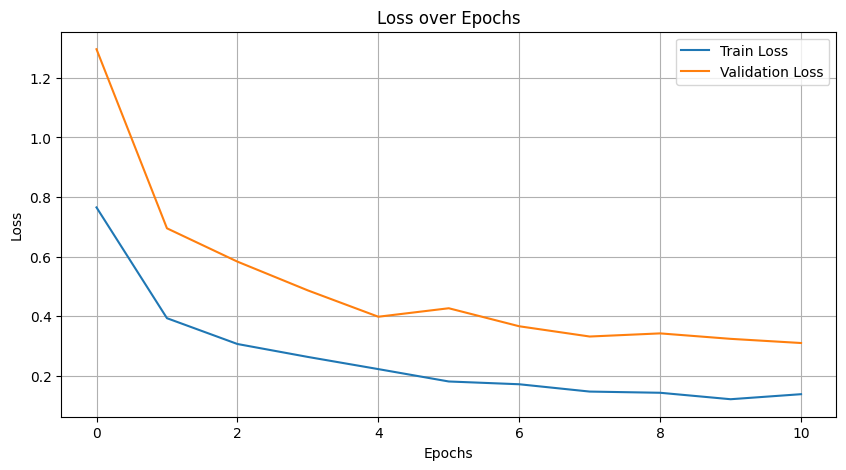

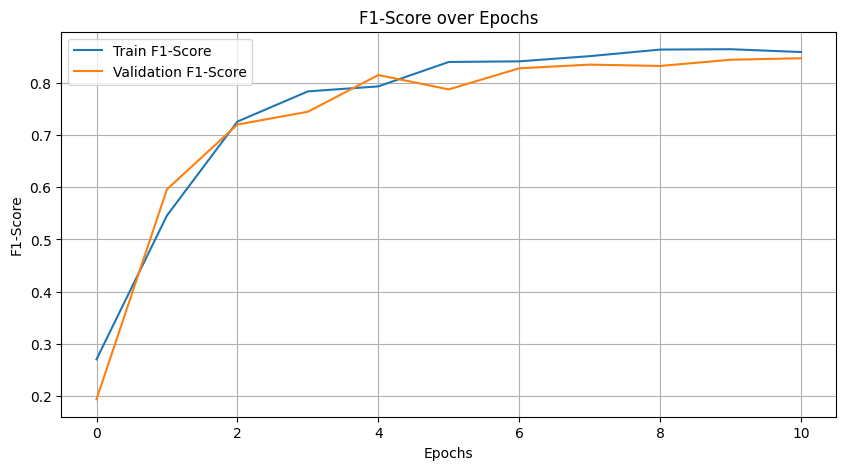

In [ ]:
def plot_metrics(metrics_history):
    plt.figure(figsize=(10, 5))
    plt.plot(metrics_history['train_loss'], label='Train Loss')
    plt.plot(metrics_history['valid_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(metrics_history['train_f1'], label='Train F1-Score')
    plt.plot(metrics_history['valid_f1'], label='Validation F1-Score')
    plt.title('F1-Score over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid()
    plt.show()

plot_metrics(metrics_history)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_true = []
y_pred = []

model.eval()
with torch.no_grad(): 
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset['test'].classes))


Accuracy: 0.9017
F1-Score: 0.9036
Classification Report:
              precision    recall  f1-score   support

       Degas       0.80      1.00      0.89        32
     Lorrain       0.67      1.00      0.80         6
       Monet       0.88      0.96      0.92        69
       Munch       0.64      0.90      0.75        10
     Poussin       0.83      1.00      0.91        10
      Renoir       0.97      0.89      0.93        71
     VanGogh       1.00      0.82      0.90        97

    accuracy                           0.90       295
   macro avg       0.83      0.94      0.87       295
weighted avg       0.92      0.90      0.90       295



In [55]:
name = class_names

In [ ]:
import torch

model.eval()

correct = 0
total = 0

with torch.no_grad():  
    for inputs, labels in train_loader:  
        inputs, labels = inputs.to(device), labels.to(device) 
        outputs = model(inputs)  
        _, predicted = torch.max(outputs, 1)  
        total += labels.size(0)  
        correct += (predicted == labels).sum().item()  

accuracy = 100 * correct / total
print(f"Prediction accuracy on train data = {accuracy:.2f}%")


Prediction accuracy on train data = 89.41%


In [70]:
model.eval()

correct = 0
total = 0

with torch.no_grad():  
    for inputs, labels in valid_loader:  
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) 
        total += labels.size(0)  
        correct += (predicted == labels).sum().item() 

accuracy = 100 * correct / total
print(f"Prediction accuracy on validation data = {accuracy:.2f}%")


Prediction accuracy on validation data = 84.12%


In [71]:
model.eval()

correct = 0
total = 0

with torch.no_grad():  
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Dokładność klasyfikacji na zbiorze testowym = {accuracy:.2f}%")

Dokładność klasyfikacji na zbiorze testowym = 90.17%


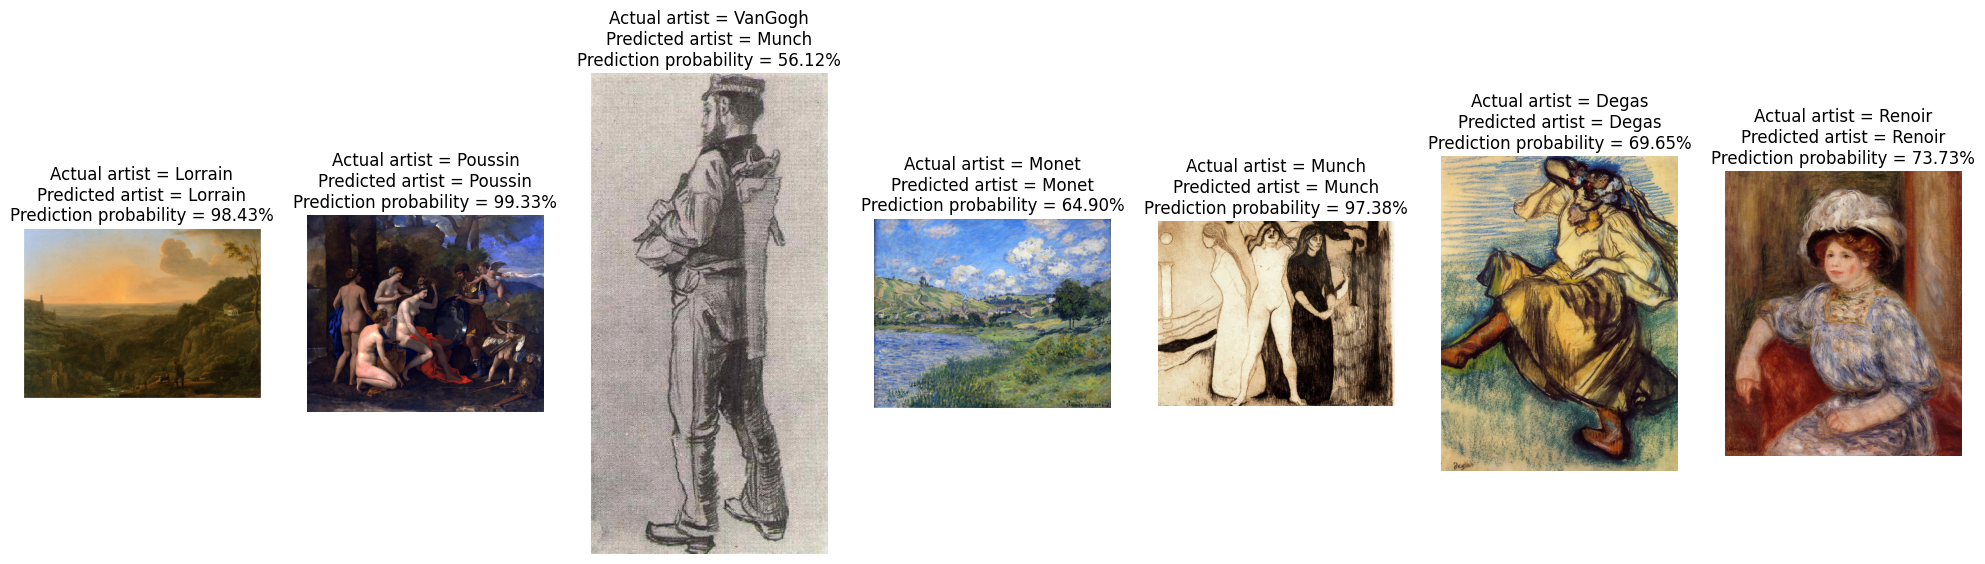

In [76]:
from keras.preprocessing.image import load_img, img_to_array
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

n = 7
fig, axes = plt.subplots(1, n, figsize=(25, 10))

unique_artists = set()

while len(unique_artists) < n:
    random_artist = random.choice(name)
    unique_artists.add(random_artist)

for i, random_artist in enumerate(unique_artists):
    random_image = random.choice(os.listdir(os.path.join(test_directory, random_artist)))
    random_image_file = os.path.join(test_directory, random_artist, random_image)

    test_image = load_img(random_image_file, target_size=(224, 224))  
    test_image = img_to_array(test_image)
    test_image /= 255.0 
    test_image = np.expand_dims(test_image, axis=0) 

    test_tensor = torch.tensor(test_image, device=device).permute(0, 3, 1, 2)  

    with torch.no_grad():
        prediction = model(test_tensor)
        prediction_probability = torch.max(torch.softmax(prediction, dim=1)).item()
        prediction_idx = torch.argmax(prediction, dim=1).item()

    labels = {idx: class_name for idx, class_name in enumerate(dataset['train'].classes)}

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f}%" \
        .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '), prediction_probability * 100)

    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()                                                                                              
